In [1]:
import os
import random
from glob import glob
from tqdm import tqdm
from multiprocessing import Pool

import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print("TensorFlow:", tf.__version__)
# Set seed for experiment reproducibility
seed = 777
tf.random.set_seed(seed)

TensorFlow: 2.10.0


In [2]:
utt_path = 'asr_bengali/utt_spk_text.tsv'
flac_audio_dir = 'asr_bengali/data'

max_target_len = 30

In [3]:
FILTER_CHARS = [
    '"', '%', "'", ',', '-', '.', '/', '\x93', '\x94', '\u200c', '\u200d', '‘', 
    '’', '“', '”', '…', '!', ':', ';', '?', 'œ', '।', '–'
]

ENGLISH = set([
    '0', '1', '2', '3', '4', '5', 'B', 'L', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 
    'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'z',
])


def clean(text):
    '''Clean text'''
    for c in FILTER_CHARS:
        if c in text:
            text = text.replace(c, '')
    return text


def is_contrain_english_chars(text):
    if ENGLISH.intersection(set(text)):
        return True
    return False 

def convert_flac_to_wav(f):
    print('Rony')
    cmd = f"sox {f} {f.split('.')[0] + '.wav'}"
    os.system(cmd)

def get_data(utt_path, flac_audio_dir):
    '''Get data from utt, flac audio dir
    '''
    _take = 5000
    flac_audio_files = glob(flac_audio_dir + '/*/*.flac')[:_take*2]

    #print(f"Converting flac to wav")
    print(f"Converting flac to wav")
    for f in tqdm(flac_audio_files):
        cmd = f"sox {f} {f.split('.')[0] + '.wav'}"
        os.system(cmd)
    print('done')
    
    flac_list = [
        os.path.splitext(os.path.basename(_file))[0] 
        for _file in flac_audio_files
    ]
    flac_set = set(flac_list)

    data = []
    unique_chars = set()
    max_text_len = 0
    max_text = ''
    en_bn_mixed = 0
    takes = 0
    audio_duration = 0
    unique_words = set()
    with open(utt_path, 'r',encoding='utf-8') as fp:
        lines = fp.readlines()
        for line in tqdm(lines, total=len(lines)):
            line = line.strip(' \n')
            line = line.split('\t')
            file_name, text= line[0], line[2]
    
            if takes >= _take:
                break

            if file_name in flac_set:
                text = clean(text)
                # skip text which has > max_target_len chars
                if len(text) > max_target_len:
                    continue
                
                # skip english text
                if is_contrain_english_chars(text):
                    en_bn_mixed += 1
                    continue
                
                file_abs_path = flac_audio_files[flac_list.index(file_name)].split('.')[0] + '.wav'
                data.append({'audio': file_abs_path, 'text': text})
                duration = librosa.get_duration(filename=file_abs_path)
                audio_duration += duration
                # create unique chars set
                for c in text:
                    unique_chars.add(c)
                
                words = text.split()
                for w in words:
                    unique_words.add(w)
                
                # find max text sequence lenght, text
                text_len = len(text)
                if max_text_len < text_len:
                    max_text_len = text_len
                    max_text = text
                
                takes += 1
                
    unique_chars = sorted(unique_chars)

    print(f'flac audio files: {len(flac_audio_files)}')
    print(f'flac_dic         : {len(flac_set)}')
    print(f'utt entry       : {len(lines)}')
    print(f'unique chars  : {len(unique_chars)}')
    print(f'data             : {len(data)}')
    print(f"max text length : {max_text_len}")
    print(f'max text          : {max_text}')
    print(f'en bn mixed     : {en_bn_mixed}')
    print(f"Total unique words: {len(unique_words)}")
    print(f"audio duration: {audio_duration / 3600:.3f} hr")
 
    return data, unique_chars

In [4]:
data, unique_chars = get_data(utt_path, flac_audio_dir)
print('chars:', unique_chars)

Converting flac to wav


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:15<00:00, 14.80it/s]


done


  0%|                                                                                       | 0/218703 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_11108\2222715248.py:80: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_abs_path)
  2%|█▊                                                                        | 5403/218703 [06:55<4:33:18, 13.01it/s]

flac audio files: 10000
flac_dic         : 10000
utt entry       : 218703
unique chars  : 70
data             : 5000
max text length : 30
max text          : বা অ্যালার্জির বংশগত রোগ যুক্ত
en bn mixed     : 2
Total unique words: 6661
audio duration: 4.731 hr
chars: [' ', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'য়', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']


In [5]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid,trainable=False)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid,trainable=False)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

    
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes, activation='softmax') ####softmax#activtion function

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    @tf.function
    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        # print('test preds', preds.numpy)
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [6]:
import Levenshtein

def calculate_wer(reference, hypothesis):
    reference = reference.split()
    hypothesis = hypothesis.split()
    
    return Levenshtein.distance(reference, hypothesis) / len(reference)


In [7]:
def calculate_cer(reference, hypothesis):
    reference = reference.replace(' ', '')
    hypothesis = hypothesis.replace(' ', '')

    if len(reference) == 0:
        return len(hypothesis)
    
    distance = Levenshtein.distance(reference, hypothesis)
    return distance / len(reference)



In [8]:
wer_values = []
cer_values = []

In [9]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token


    def on_epoch_end(self, epoch, logs=None):
        self.batch = batch = next(iter(val_ds))
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        total_wer = 0.0
        total_cer = 0.0

        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break

            # Calculate WER and CER
            

            
            target_text= target_text.replace('-', '')
            wer = calculate_wer(target_text, prediction)
            cer = calculate_cer(target_text, prediction)
            total_wer += wer
            total_cer += cer

            print(f"target:     {target_text}")
            print(f"prediction: {prediction}")
            #print(f"WER: {wer:.4f}, CER: {cer:.4f}")

        # Calculate and print average WER and CER
        avg_wer = total_wer / tf.cast(bs, dtype=tf.float32)
        avg_cer = total_cer / tf.cast(bs, dtype=tf.float32)
        print(f"Average WER: {avg_wer:.4f}, Average CER: {avg_cer:.4f}")
        wer_values.append(avg_wer)
        cer_values.append(avg_cer)
        

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        lr =  tf.math.minimum(warmup_lr, decay_lr)
        return lr

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)


In [10]:
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + list(unique_chars)
            # + [chr(i + 96) for i in range(1, 27)]
            # + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        # text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


# data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft#######################################################################
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)    
    # audio = tf.cast(tfio.audio.decode_flac(audio, dtype=tf.int16), tf.float32)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)#       fft
    x = tf.math.pow(tf.abs(stfts), 0.5)
    audio_len = tf.shape(x)[0]
    # padding to 10 seconds
    pad_len = 1700 # 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
#     print('paddings shape:', tf.shape(paddings))
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
#     print('final audio len:', tf.shape(x))
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return audio_ds

# @tf.function
def create_tf_dataset(data, bs=4, val_data=False):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    # cashe data to RAM 
    ds = ds.cache()
    # do shuffle
    ds = ds.shuffle(1000)
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

data = data
split = int(len(data) * 0.99)
train_data = data # data[:split]
test_data =  data[split:]
# ds = create_tf_dataset(train_data, bs=400)
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=64)

vocab size 74


In [11]:
print(f"Total test data: {len(test_data)}")

Total test data: 50


In [12]:
import IPython
import random
for i in range(5):
    idx = random.randint(0, len(train_data))
    item = train_data[idx]
    print(item["text"])
    IPython.display.display(IPython.display.Audio(item["audio"]))

স্যামসাং


যেসব খাবার খাওয়া হচ্ছে


সবচেয়ে পুরনো লেখা হল


ঝড়


ফতেহ খান সপরিবারে


In [13]:
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=128,
    num_head=2,
    num_feed_forward=256,
    target_maxlen=max_target_len,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=len(vectorizer.get_vocabulary()) # 75 # 48 # 67 # 108,
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0.1,
)
##############################Loss function
learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate)#Adam optimizer
# optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Adam(lr=0.00005)

# model.compile(optimizer=optimizer, loss=loss_fn)
model.compile(optimizer=optimizer, loss=loss_fn)
# model.load_weights('/content/gdrive/MyDrive/bangla-ai/models/bnasr-57')
# latest = tf.train.latest_checkpoint('/content/drive/MyDrive/bangla-ai/models/08-04-2021_ID_03')
# model.load_weights(latest)

In [14]:
if not os.path.exists("asr-checkpoint"):
    os.makedirs("asr-checkpoint")

checkpoint_path = 'asr-checkpoint/bnasr-{epoch:02d}-{val_loss:0.6f}'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

print("tf.executing_eagerly():", tf.executing_eagerly())

# optimizer = keras.optimizers.Adam(lr=0.0001)
# model.compile(optimizer=optimizer, loss=loss_fn)
history = model.fit(
    ds, 
    validation_data=val_ds, 
    callbacks=[display_cb],
    initial_epoch=0,
    epochs=40
)

tf.executing_eagerly(): True
Epoch 1/40
79/79 [==============================] - ETA: 0s - loss: 3.0029target:     <কিন্তু যারা এধরনের আত্মঘাতী>
prediction: <ব িেহে ংুরেম৭খজেমে িরে>
target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <এর পর সময়ের স্রোত>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <মুলতবি করেন>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <রুনু খালার ফ্রক পরা>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরঐষরা ঔও 
target:     <তাদের সৎ মাকে>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরঐষরা ঔও 
target:     <দক্ষিণ এশিয়ায়>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <তখন সে তার মায়ের সঙ্গে>
prediction: <ব িেহে ংুরেম৭খজেমে িরঐষরা ঔও 
target:     <বুক করে রেখেছেন>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরঐষরা ঔও 
target:     <ফিস>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <এক অভিনব পদ্ধতি>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <১ চাচামচ>
prediction: <ব িেহে ংুরেম৭খজেংঐ িরে>
target:     <বেলপাতা দিবি না কাউরে>
prediction: <ব িেহে ংুর

Epoch 4/40
79/79 [==============================] - ETA: 0s - loss: 2.0119target:     <পরের বছর>
prediction: <বার কে কের বার>
target:     <কে অস্বীকার করবে>
prediction: <বিন কে কের বে>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <বিন কে কের বে>
target:     <দুটো নুড়ি>
prediction: <বার কে কের বে>
target:     <রচিত গ্রন্থ>
prediction: <বিন কে কের বে>
target:     <দোষী সাব্যস্ত করে>
prediction: <বার কে কের বারে>
target:     <দক্ষিণ এশিয়ায়>
prediction: <বিন কে কের বে>
target:     <উদ্ধার করে র্যাব>
prediction: <বার কে কের বারে>
target:     <ফুচকা>
prediction: <বার কে কের বার>
target:     <পাওয়া যায়না>
prediction: <বার কে কের কে>
target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <বার কর কর প্র কে>
target:     <বিশ্বভ্রমণের অপার আনন্দ>
prediction: <এক্ত কর বে বারে>
target:     <তথ্য ও যোগাযোগ প্রযুক্তি আইন>
prediction: <বার কে কের বে>
target:     <এক অভিনব পদ্ধতি>
prediction: <বার কে কের বে>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
prediction: <এক্ত কর বে বারে>
target:     <ফিস>

Epoch 7/40
79/79 [==============================] - ETA: 0s - loss: 1.8825target:     <এক বাংলাদেশিকে>
prediction: <তার কের বারে>
target:     <অপরদিকে গণভোটটিকে বেআইনি বলে>
prediction: <বিনি বিনি প্রিনিনিনিয়ে>
target:     <শবে মেরাজ এর ঘটনা>
prediction: <সের পারার পারানে>
target:     <মুলতবি করেন>
prediction: <বলে পার বা>
target:     <তল্লাশি চালায় গোয়েন্দা পুল>
prediction: <তার কারা কারারার কে>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সেনি সের কে>
target:     <পাওয়া যায়না>
prediction: <তার কারা>
target:     <১ চাচামচ>
prediction: <সার কের সা>
target:     <কুরআন>
prediction: <তার কা>
target:     <কিন্তু যারা এধরনের আত্মঘাতী>
prediction: <এক পার পারারার কা>
target:     <আমার ভালবাসা শুধু তোমার জন্য>
prediction: <তার কার বারান্য়ে>
target:     <রুনু খালার ফ্রক পরা>
prediction: <বার প্রার প্যান>
target:     <রাজনৈতিক দলগুলোর মধ্যে সংঘাত>
prediction: <তারা পারা পারারা>
target:     <এক অভিনব পদ্ধতি>
prediction: <তার কার বারে>
target:     <বুক করে রেখেছেন>
prediction: <তার কের

Epoch 10/40
79/79 [==============================] - ETA: 0s - loss: 1.7322target:     <এর পর সময়ের স্রোত>
prediction: <এস্ষ্য স্রকর স্যানেছেছে>
target:     <নামে এক যুবক>
prediction: <মারানের ক্য়ে>
target:     <কুরআন>
prediction: <কোনা>
target:     <তখন সে তার মায়ের সঙ্গে>
prediction: <পর্র্র্র সমাযান্যাযায়ে>
target:     <ফিলিস্তিনিদের নেতা>
prediction: <কিন্তি ক্রাক্যাকা>
target:     <দোষী সাব্যস্ত করে>
prediction: <এসাক সাকর স্য়েছে>
target:     <তল্লাশি চালায় গোয়েন্দা পুল>
prediction: <কর্তার কারার কান্যায়ের ন্য়>
target:     <মুলতবি করেন>
prediction: <মুক্তিক করে>
target:     <রুনু খালার ফ্রক পরা>
prediction: <প্রকর্ত করারা>
target:     <কিন্তু যারা এধরনের আত্মঘাতী>
prediction: <কিক্ত্ত করারারা করাক্তেরেরে>
target:     <কে অস্বীকার করবে>
prediction: <একটা কর্যা করিকরে>
target:     <শবে মেরাজ এর ঘটনা>
prediction: <সম্যার ক্রাকেরাকে নার না>
target:     <সৃষ্টির জন্য যথেষ্ট>
prediction: <সিক্ত্তিক ক্র্র্ত্র করেছর>
target:     <ভিখারী সাজাইয়াছি>
prediction: <কিক্যা কারেরে সাসে

Epoch 13/40
79/79 [==============================] - ETA: 0s - loss: 1.5499target:     <ফুচকা>
prediction: <কুষ্টার কা>
target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <বারেশিয় এসিয় দিয় ব>
target:     <কে অস্বীকার করবে>
prediction: <তির আর কর্ষ্টার কর>
target:     <কুরআন>
prediction: <উলা>
target:     <উদ্ধার করে র্যাব>
prediction: <উদ্ধার করারা>
target:     <বিশ্বভ্রমণের অপার আনন্দ>
prediction: <বিশ্বা করা বল্যনে হমেয়ে নেয>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
prediction: <বারায়ার ক্তিক্ষ্রে ন>
target:     <তথ্য ও যোগাযোগ প্রযুক্তি আইন>
prediction: <তখনে আই ক্রত্রতিক্ত্র নে>
target:     <দক্ষিণ এশিয়ায়>
prediction: <বক্ষি এসিয়ায়>
target:     <কিন্তু যারা এধরনের আত্মঘাতী>
prediction: <তিন্য যাতু নাকরা আতে>
target:     <ক্রাইমিয়ায় ৬ হাজার সেনা>
prediction: <তার মিয়া নিয়া মিয়েছেনা>
target:     <ভিখারী সাজাইয়াছি>
prediction: <দিকার সাজনের য়ে যাজনেন>
target:     <বুক করে রেখেছেন>
prediction: <বলে একা একে যান>
target:     <সহঅধিনায়ক মাহমুদুল্লা>
prediction: <চার মেখন

Epoch 16/40
79/79 [==============================] - ETA: 0s - loss: 1.4009target:     <তথ্য ও যোগাযোগ প্রযুক্তি আইন>
prediction: <তখন দেখায়ে আই ক্রতে>
target:     <কে অস্বীকার করবে>
prediction: <কেও আসি করবি>
target:     <পরের বছর>
prediction: <করে বছর>
target:     <উল্লেখ করার মতো>
prediction: <উলিয়ে প্রিয়ে প্য>
target:     <আমার ভালবাসা শুধু তোমার জন্য>
prediction: <আমার বাশার বাসার জন্দর্য়ন্য>
target:     <উদ্ধার করে র্যাব>
prediction: <উদ্ধার করে করেয়া>
target:     <স্বামী সংসার>
prediction: <সাবি সহসার>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সুলিদর সঙ্গে সর্গে>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
prediction: <নারার ক্ষের প্রেক্রে>
target:     <এর মানে কি এই>
prediction: <এর কে মেকে>
target:     <১ চাচামচ>
prediction: <একটা চাছ>
target:     <ফুচকা>
prediction: <কুচ কার>
target:     <নামে এক যুবক>
prediction: <নামের যুক>
target:     <তোমরা পাঁচ জনে মিলিয়া>
prediction: <কোনা কা থাকা>
target:     <কেননা আমি যদি ধরা পড়ি>
prediction: <এমনন মিজন্য হা করা করি>
t

Epoch 19/40
79/79 [==============================] - ETA: 0s - loss: 1.2487target:     <রেবেকা সুলতানা>
prediction: <রেলে পাসহ করে>
target:     <নামে এক যুবক>
prediction: <নানের জুবু>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সুলিদুর সঙ্গলিতে নি>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
prediction: <নারার এক কটিক নারেন>
target:     <১ চাচামচ>
prediction: <চা চার চান্তি>
target:     <রাজনৈতিক দলগুলোর মধ্যে সংঘাত>
prediction: <রাজন তাবা নারা সনানা দারাতাত>
target:     <ফিস>
prediction: <ফেস>
target:     <ফুচকা>
prediction: <পুচ্তার>
target:     <ওবায়দুল কাদের জানান>
prediction: <বায় পায় রুর্ডা যাকবে>
target:     <এক অভিনব পদ্ধতি>
prediction: <এক পরবিরোগ কর্যে>
target:     <তখন সে তার মায়ের সঙ্গে>
prediction: <পাকান সে পারে সঙ্গাননে>
target:     <এক বাংলাদেশিকে>
prediction: <এই বাংলাদেছে পেল পে>
target:     <তথ্য ও যোগাযোগ প্রযুক্তি আইন>
prediction: <তদ্বত হয় অধুর্য করিক্ষাইনে>
target:     <পাওয়া যায়না>
prediction: <পাওয়ার জায়া>
target:     <সৃষ্টির জন্য যথেষ্ট>
predic

Epoch 22/40
79/79 [==============================] - ETA: 0s - loss: 1.1236target:     <১ চাচামচ>
prediction: <এব চাচামচ>
target:     <রাজনৈতিক দলগুলোর মধ্যে সংঘাত>
prediction: <রাজন মুল দুর্ধ ন হমধ্য>
target:     <রেবেকা সুলতানা>
prediction: <এরেকা কাছুল কানা>
target:     <নামে এক যুবক>
prediction: <নামের যুবু>
target:     <ওবায়দুল কাদের জানান>
prediction: <বাইটু কাবের জানাদের>
target:     <পরের বছর>
prediction: <করে বছর>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সুনিদ্ধরের সঙ্গে নিযে>
target:     <সহঅধিনায়ক মাহমুদুল্লা>
prediction: <সহাহামাল দল হান্য না>
target:     <স্বামী সংসার>
prediction: <স্বামী সংসার>
target:     <সৃষ্টির জন্য যথেষ্ট>
prediction: <সিস্টির জন্য অন্য>
target:     <ফিলিস্তিনিদের নেতা>
prediction: <কিলিনের ইস্তিনের>
target:     <অপরদিকে গণভোটটিকে বেআইনি বলে>
prediction: <অপরদিকে বলোধে বল করতিকেইনি>
target:     <তাদের সৎ মাকে>
prediction: <তাদের সবে>
target:     <এর মানে কি এই>
prediction: <এর মেমনে এই>
target:     <ক্রাইমিয়ায় ৬ হাজার সেনা>
prediction: 

Epoch 25/40
79/79 [==============================] - ETA: 0s - loss: 1.0332target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <মালেশি প্রতিনিরিদিদিদন্ধার>
target:     <তারা তিনবার চেষ্টা করেও>
prediction: <তারা তিনবা চেষ্টা করেও>
target:     <সহঅধিনায়ক মাহমুদুল্লা>
prediction: <সহজনা ও হাওয়ন্ত নদুলা>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
prediction: <নারা রে পক্ষে পক্ষেত্রার>
target:     <লাবেলের ভাষ্য মতে>
prediction: <না বেলের বাসমুদে>
target:     <নামে এক যুবক>
prediction: <নামের জোক>
target:     <সৃষ্টির জন্য যথেষ্ট>
prediction: <সিস্টিস্ট জন্য জন্য>
target:     <পাওয়া যায়না>
prediction: <পাওয়া যা>
target:     <উল্লেখ করার মতো>
prediction: <উল্যান করায় মতো>
target:     <পরের বছর>
prediction: <পরের বছর>
target:     <ক্রাইমিয়ায় ৬ হাজার সেনা>
prediction: <ক্রায় মিয়াজা মিয়াদা>
target:     <চুল পরিস্কার রাখা>
prediction: <চুল পরিশ্কার রাখা>
target:     <ভিখারী সাজাইয়াছি>
prediction: <দিকারি সাজায়িয়াছি>
target:     <ওবায়দুল কাদের জানান>
prediction: <পাইটুল কাদের যাদের 

Epoch 28/40
79/79 [==============================] - ETA: 0s - loss: 0.9428target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সুহিদুল্ল্যায় সহয়ে নে>
target:     <দক্ষিণ এশিয়ায়>
prediction: <দক্ষিল্পীয়ায়>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
prediction: <লারায়লে পক্ষে হ্যারিক্য়>
target:     <তল্লাশি চালায় গোয়েন্দা পুল>
prediction: <তল্ল সালায় হয় বইল্ল্লাসেলা>
target:     <হিটলারের জীবন কাহিনী>
prediction: <হিটি জারে জিনি>
target:     <ক্রাইমিয়ায় ৬ হাজার সেনা>
prediction: <ক্রায় নিয়ায় নিয়া আদাদর>
target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <মালেশির প্রতিনিরিদির দিদলিদ>
target:     <রেবেকা সুলতানা>
prediction: <গড়ে কাছুল কালা>
target:     <অপরদিকে গণভোটটিকে বেআইনি বলে>
prediction: <অপরবিকে বলোপর বেইনি বলেই বলে>
target:     <তথ্য ও যোগাযোগ প্রযুক্তি আইন>
prediction: <তথ্বাযো কোটিবা ক্রহাযুনেনে>
target:     <উল্লেখ করার মতো>
prediction: <উল্লেখ করার মতো>
target:     <ফিস>
prediction: <ফিলস>
target:     <নামে এক যুবক>
prediction: <নামের দক>
target:     <শবে মের

Epoch 31/40
79/79 [==============================] - ETA: 0s - loss: 0.8674target:     <বিশ্বভ্রমণের অপার আনন্দ>
prediction: <বিশ্বীসুধ্ব পাড়ার অপারণেয়ে>
target:     <নামে এক যুবক>
prediction: <নামেই তোবক>
target:     <এক বাংলাদেশিকে>
prediction: <এক বাংলাদেশিকে>
target:     <সৃষ্টির জন্য যথেষ্ট>
prediction: <সিস্টির যা যাথেক য়েশ য>
target:     <এক অভিনব পদ্ধতি>
prediction: <এক অভিনব পদ্ব তি>
target:     <ফুচকা>
prediction: <ফুচকা>
target:     <রচিত গ্রন্থ>
prediction: <প্রযিত বন্ধ>
target:     <ফিলিস্তিনিদের নেতা>
prediction: <চিলিনের প্রিডেটা>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সৈনি দুল্য সৈনিতে নি>
target:     <কিন্তু যারা এধরনের আত্মঘাতী>
prediction: <কিন্তু যারাত্বা রাত্রমায় হত>
target:     <এর মানে কি এই>
prediction: <এর মানে কিয়েই>
target:     <দুটো নুড়ি>
prediction: <দুটো মুড়ি>
target:     <তথ্য ও যোগাযোগ প্রযুক্তি আইন>
prediction: <তথ্য ও যযোগাযোগ প্রযুক্তিযুক>
target:     <তখন সে তার মায়ের সঙ্গে>
prediction: <তখন সে তার মায়ের সঙ্গে>
target:     <ওবায়

Epoch 34/40
79/79 [==============================] - ETA: 0s - loss: 0.7986target:     <তল্লাশি চালায় গোয়েন্দা পুল>
prediction: <তল্লাশি চালায় বয়েন্দার পুল>
target:     <চুল পরিস্কার রাখা>
prediction: <চুল পরিশ্কারা>
target:     <তাদের সৎ মাকে>
prediction: <তাদের সবে>
target:     <কে অস্বীকার করবে>
prediction: <কে অস্বার করবে>
target:     <রাজনৈতিক দলগুলোর মধ্যে সংঘাত>
prediction: <রাজনৈতিক দলগুলোর মধ্যে সংগে>
target:     <নামে এক যুবক>
prediction: <নামের দুবক>
target:     <পরের বছর>
prediction: <পরের বছর>
target:     <তারা তিনবার চেষ্টা করেও>
prediction: <তারা তিনবার চেষ্টা করেও>
target:     <হিটলারের জীবন কাহিনী>
prediction: <হিটলারের জীবনকাহিনি>
target:     <ভিখারী সাজাইয়াছি>
prediction: <বিকারি সাজাইয়াছি>
target:     <ছবির গল্প চিত্রনাট্য ও শৈলীত>
prediction: <সবির্দর বছির জড়ইল্যারিতে>
target:     <এর পর সময়ের স্রোত>
prediction: <এর পর সময়ের স্রোত>
target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <মালেশিয় প্রতিনিরিয়েদ দল>
target:     <নড়াইলের পক্ষে হ্যাটট্রিক কর>
predi

Epoch 37/40
79/79 [==============================] - ETA: 0s - loss: 0.7502target:     <দোষী সাব্যস্ত করে>
prediction: <দোষি সাবস্ত করে>
target:     <পরের বছর>
prediction: <পরের বছর>
target:     <রেবেকা সুলতানা>
prediction: <রেবেকা সুলামাহিকানা>
target:     <চুল পরিস্কার রাখা>
prediction: <চুল পরিশ্কার রাখা>
target:     <এর পর সময়ের স্রোত>
prediction: <এর পর সময়ের স্রক্র>
target:     <শহিদুল্লাহ শহিদের মেয়ে>
prediction: <সমি দুল্লের সঙ্গে মেয়ে>
target:     <এক অভিনব পদ্ধতি>
prediction: <এক অভিনব পদ্ধতি>
target:     <ফুচকা>
prediction: <খুচকা>
target:     <তাদের সৎ মাকে>
prediction: <তাদের সবে>
target:     <মালয়েশীয় প্রতিনিধি দল>
prediction: <মালিয়েশিয় প্রতিনিটি দ>
target:     <বুক করে রেখেছেন>
prediction: <বুক করে রেখেছেন>
target:     <সৃষ্টির জন্য যথেষ্ট>
prediction: <সিস্টির জন্য যথেক যথেষ>
target:     <কুরআন>
prediction: <কুরান>
target:     <মুলতবি করেন>
prediction: <মূলতবি করেন>
target:     <ফিলিস্তিনিদের নেতা>
prediction: <ফিলিস্তিনিদের নেতা>
target:     <রাজনৈতিক দলগুলোর 

Epoch 40/40
79/79 [==============================] - ETA: 0s - loss: 0.7083target:     <শবে মেরাজ এর ঘটনা>
prediction: <সবে মেয়াছ এর মের ঘটা>
target:     <চুল পরিস্কার রাখা>
prediction: <চুল পরিস্কার রাখা>
target:     <কে অস্বীকার করবে>
prediction: <কে অস্বীযার করবে>
target:     <তখন সে তার মায়ের সঙ্গে>
prediction: <পান সে তার মায়ের সঙ্গে>
target:     <এক বাংলাদেশিকে>
prediction: <এক বাংলাদেশিকে>
target:     <সহঅধিনায়ক মাহমুদুল্লা>
prediction: <সহা অজুধা হমুদুল ন্লা>
target:     <স্বামী সংসার>
prediction: <স্বামী সংসার>
target:     <তাদের সৎ মাকে>
prediction: <তাদের সবেই মাকে>
target:     <দক্ষিণ এশিয়ায়>
prediction: <দক্ষিণ এসিয়ায়>
target:     <এক অভিনব পদ্ধতি>
prediction: <এক অভিনব পদ্ধতি>
target:     <লাবেলের ভাষ্য মতে>
prediction: <লাবেলের ভাষ্য মতেরন>
target:     <কিন্তু যারা এধরনের আত্মঘাতী>
prediction: <কিন্তু যারা এধরনের আত্মঘাতী>
target:     <মুলতবি করেন>
prediction: <মুলত বি করেন>
target:     <উদ্ধার করে র্যাব>
prediction: <উদ্ধার করে রেড়াব>
target:     <ফুচকা>
predic

In [15]:
total_params = model.count_params()
trainable_params = sum(p.trainable for p in model.trainable_weights)
non_trainable_params = total_params - trainable_params

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

Total parameters: 1292748
Trainable parameters: 67
Non-trainable parameters: 1292681


In [16]:
"""import json

# Assuming you have already trained your model and have the 'history' object

# Create a dictionary to store the loss values
loss_data = {
    'training_loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
}

# Define the filename where you want to save the loss data
filename = 'loss_data.json'

# Save the loss data to a JSON file
with open(filename, 'w') as json_file:
    json.dump(loss_data, json_file)

print(f"Loss data saved to {filename}")"""

'import json\n\n# Assuming you have already trained your model and have the \'history\' object\n\n# Create a dictionary to store the loss values\nloss_data = {\n    \'training_loss\': history.history[\'loss\'],\n    \'validation_loss\': history.history[\'val_loss\']\n}\n\n# Define the filename where you want to save the loss data\nfilename = \'loss_data.json\'\n\n# Save the loss data to a JSON file\nwith open(filename, \'w\') as json_file:\n    json.dump(loss_data, json_file)\n\nprint(f"Loss data saved to {filename}")'

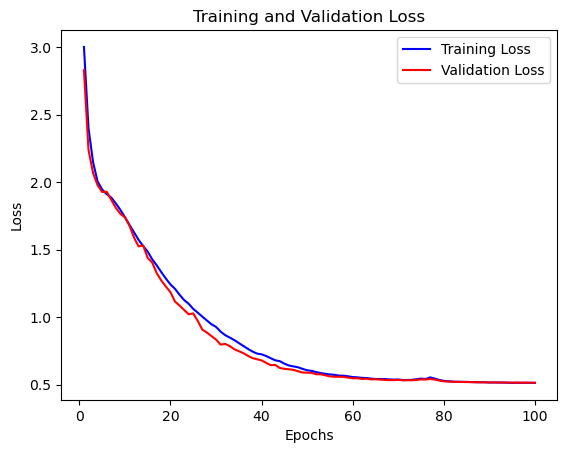

In [89]:
import json
import matplotlib.pyplot as plt

# Load the loss data from the JSON file
filename = 'loss_data.json'

with open(filename, 'r') as json_file:
    loss_data = json.load(json_file)

# Access the loss values
training_loss = loss_data['training_loss']
validation_loss = loss_data['validation_loss']

# Plot the loss curves
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

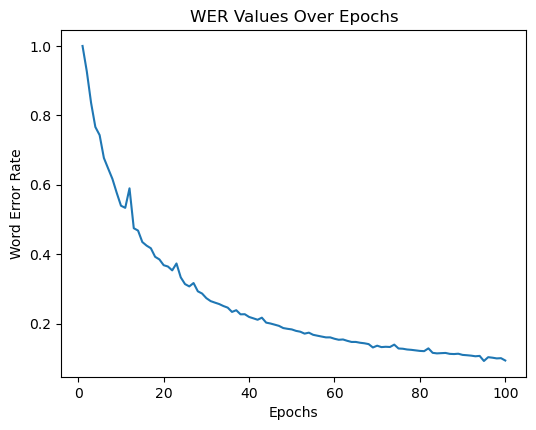

In [7]:
import json
import matplotlib.pyplot as plt

# Load WER values from the JSON file
json_file_name = 'wer_values.json'  # Replace with the actual JSON file name
with open(json_file_name, 'r') as json_file:
    wer_values = json.load(json_file)

# Create a list of epochs (assuming one epoch per WER value)
epochs = list(range(1, len(wer_values) + 1))

# Create a line plot
plt.figure(figsize=(6, 4.5))
plt.plot(epochs, wer_values)

# Label the axes
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')

# Add a title
plt.title('WER Values Over Epochs')

# Show the plot
plt.show()


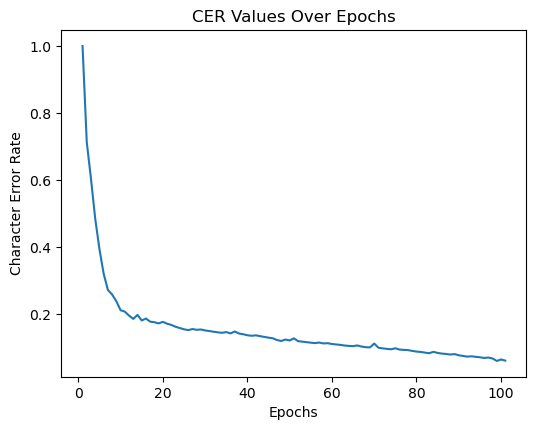

In [8]:
import json
import matplotlib.pyplot as plt

# Load WER values from the JSON file
json_file_name = 'cer_values.json'  # Replace with the actual JSON file name
with open(json_file_name, 'r') as json_file:
    cer_values = json.load(json_file)

# Create a list of epochs (assuming one epoch per WER value)
epochs = list(range(1, len(cer_values) + 1))

# Create a line plotplt.figure(figsize=(6, 4.5))
plt.figure(figsize=(6, 4.5))
plt.plot(epochs, cer_values)

# Label the axes
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')

# Add a title
plt.title('CER Values Over Epochs')

# Show the plot
plt.show()

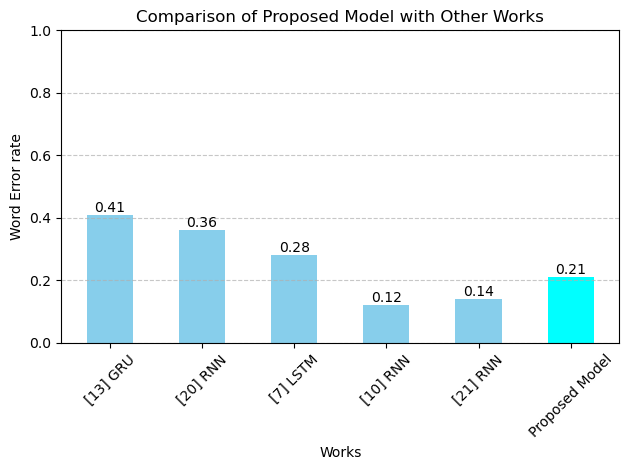

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Names of the works (including your proposed model)
works = ['[13] GRU', '[20] RNN', '[7] LSTM', '[10] RNN', '[21] RNN', 'Proposed Model']

# Accuracy scores for each work
accuracy_scores = [0.41, 0.36, 0.28, .12, 0.14, 0.21]  # Replace with your actual scores

# Create a bar chart
plt.bar(works, accuracy_scores, color=['skyblue', 'skyblue', 'skyblue', 'skyblue', 'skyblue', 'cyan'],width=.5)

# Label the axes
plt.xlabel('Works')
plt.ylabel('Word Error rate')

# Add a title
plt.title('Comparison of Proposed Model with Other Works')

# Show the plot
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1 (adjust as needed)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a horizontal grid

# Display the accuracy scores on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [2]:
import json

# Define the filename where the loss data is stored
filename = 'loss_data.json'

# Initialize empty arrays to store the loss values
loss = []
val_loss = []

# Load the loss data from the JSON file
with open(filename, 'r') as json_file:
    loss_data = json.load(json_file)

# Extract the loss values and store them in the arrays
loss = loss_data['training_loss']
val_loss = loss_data['validation_loss']
print(loss)
print(val_loss)
# Now, 'loss' contains training loss values, and 'val_loss' contains validation loss values


[3.0020551681518555, 2.4011805057525635, 2.147768259048462, 2.0047543048858643, 1.945590615272522, 1.910786747932434, 1.8855946063995361, 1.842551350593567, 1.7949066162109375, 1.7404314279556274, 1.6834096908569336, 1.6281137466430664, 1.5722802877426147, 1.526379942893982, 1.4853049516677856, 1.4274803400039673, 1.382576584815979, 1.3322547674179077, 1.2851022481918335, 1.24211847782135, 1.2092678546905518, 1.1654739379882812, 1.126137375831604, 1.0987194776535034, 1.06058669090271, 1.0325055122375488, 1.0032252073287964, 0.9748845100402832, 0.9468896389007568, 0.9277300238609314, 0.8925373554229736, 0.8666883111000061, 0.8486357927322388, 0.8297567367553711, 0.8080180287361145, 0.7862934470176697, 0.7646925449371338, 0.7450370788574219, 0.7297474145889282, 0.7244846224784851, 0.7117959856987, 0.6955004334449768, 0.6800566911697388, 0.6738126873970032, 0.6552700400352478, 0.6415431499481201, 0.6347799897193909, 0.6285171508789062, 0.6162521839141846, 0.6063067317008972, 0.60148227214